<center>
<h1>Факультет "Прикладная математика" МАИ</h1>
<h2>Курс "Основы Python для анализа данных"</h2>
<h2>Артамонов Игорь Михайлович</h2>
</center>

<center><h2>Занятие № 9. Деревья решений. k ближайших соседей.</h2></center>

## Общение / вопросы по курсу

Платформа для групповой работы Atlassian Confluence факультета "Прикладная математика"

https://mai.moscow/display/PYTML

* <b>Занятие № 9. Задачи машинного обучения. Деревья решений. k ближайших соседей.</b>

## virtualenv + Jupyter notebook

```
<Ctrl> + <Alt> + T - новое окно терминала
```

```
$ conda -V

$ conda update conda

$ conda search "^python$"

$ conda create -n yourenvname python=x.x anaconda

$ source activate yourenvname

$ jupyter notebook

$ conda install -n yourenvname [package]
```

##  Деревья решений. k ближайших соседей. Кросс-энтропия.  Выбор моделей.</h2></center>

#### Задачи машинного обучения
* регрессия
* классификация
* кластеризация

#### Обычный порядок действий
* получить "сырые" данные
* понять, что они из себя представляют (см. EDA)
* привести их в вид, пригодный для обучения модели
* разбить тренировочную выборку на две: обучающую и проверочную (валидационную)
* сравнить несколько алгоритмов машинного обучения, их настроек, чтобы получить наилучший результат для P на валидационной выборке
* (_возможно_) повторить предыдущие три этапа несколько раз
* обучить "лучшую" модель на всей тренировочной выборке
* использовать модель для получения каких-то результатов
* (_возможно_) провести дообучение модели с полученными свежими данными

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
from numpy.random import randn
import seaborn as sns
from scipy import stats

%matplotlib inline

In [2]:
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score

from sklearn.metrics import accuracy_score 

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [3]:
import os
import os.path

## Машинное обучение

__Определение.__ Мы считаем, что компьютерная программа __обучается__ при решении какой-то задачи из __класса  T__, если ее производительность, согласно __метрике P__, улучшается при накоплении __опыта E__.


T. Mitchell "Machine learning", 1997
https://www.cs.ubbcluj.ro/~gabis/ml/ml-books/McGrawHill%20-%20Machine%20Learning%20-Tom%20Mitchell.pdf

* есть класс задач T
* есть метрика производительности P
* есть понятие опыта E

Примеры задач:
* задача распзнавания изображений
* задача классификации новых объектов
* задача обучения игре

## <font color=green>ВОПРОС</font>

Где здесь __T, P__ и  __E__?
* задача распзнавания изображений
<br>T - класс задач кластеризации (иногда классификации), P - точность выделенных объектов, E - количество картинок в обучающей выборке

### Классификация алгоритмов машинного обучения

Алгоритмы машинного обучения делятся на:
* обучающиеся с учителем (__supervised__ learning).
* обучающиеся без учителя (__unsupervised__ learning).
* с подкреплением (__reinforcement__ learning).
* смешанное  (__semisupervised__ learning).<br><br>

Общее в этих задачах - наличие некоторой выборки данных (информации об объектах), 
которую называют набором признаков (__object features__). При обучении без учителя
никакой дополнительной информации, связанной с __каждым объектом__ нет.

В случе обучения __с учителем__ с каждым из объектов связывается дополнительный
целевой признак. Это то, что хотелось бы прогнозировать для прочих объектов, 
не из обучающей выборки.

Основными задачами в машинном обучении являются:
* Обучение с учителем:
    - __регрессия__ – прогнозирование количественного признака объекта на основании прочих его признаков
    - __классификация__ – отнесение объекта к одной из категорий на основании его признаков<br><br>
* Обучение без учителя:
    - __кластеризация__ – разбиение множества объектов на группы на основании анализа признаков этих объектов так, чтобы внутри групп объекты были, в некотором смысле, более "близкими" между собой, а вне одной группы – менее "близкими"

Минимальный путь машинного обучения выглядит так:
* обучиться на обучающей выборке (получить опыт E) так, чтобы на этой выборке метрика P 
достигла своего экстремума
* применить полученный опыт E к новым данным (данным за пределами обучающей выборки), чтобы сделать что-то хорошее

Более адекватный (и реалистичный) путь машинного обучения выглядит так:
* определить цель обучения (business goal)
* определить критерий оценки (метрика, preformance measure)
* получить "сырые" данные
* понять, что они из себя представляют (см. EDA)
* привести их в вид, пригодный для обучения модели
* разбить тренировочную выборку на две: обучающую и проверочную (валидационную)
* сравнить несколько алгоритмов машинного обучения, их настроек, чтобы получить наилучший результат для P на валидационной выборке
* (_возможно_) повторить предыдущие три этапа несколько раз
* обучить "лучшую" модель на всей тренировочной выборке
* использовать модель для получения каких-то результатов
* (_возможно_) провести дообучение модели с полученными

## Sklearn

* одна из основных бибилотек, используемая при машинном обучении
* содержит много качественных алгоритмов и хорошую документацию
* имеет _типовую_ логику применения

#### Обучение с учителем

* данные состоят из тренировочных и тестовых данных
* Делим тренировочную выборку на входные и выходные переменные
* Заполняем пропущенные данные (см. предыдущее занятие № 9)
* Фильтрация пропущенных данных
* Проверяем, остались ли не заполненные данные?
* Выполняем преобразование данных (смещенные распределения, логарифмирование и т.д.)
* Создаем признаки:
    * составные
    * бинарные
    * категориальные
* Создаем классификатор / регрессор
* Учим классификатор / регрессор на тренировочных данных с валидационными выборками
* Проверяем обучение классификатора на тестовой выборке
* Повторяем ...

## Метрики для регрессии. MSE / MAE 

#### Среднеквадратичное отклонение (Mean Squared Error)

$$ MSE(X, h) = \frac{1}{n}\sum_{i=1}^{n} (h(x_i) - y_i)^2$$

#### Среднее абсолютное отклонение (Mean Absolute Error)

$$ MAE(X, h) = \frac{1}{n}\sum_{i=1}^{n} \lvert h(x_i) - y_i \rvert $$

## Метрики для классификации. Кросс-энтропия
https://dementiy.github.io/notes/cross-entropy/

__Энтропия__ — это то, как много информации нам __не__ известно о системе. Это не __свойство системы__, это свойство __знания__ о системе.
<br><br>«Если вам необходимо предсказать следующий символ, то сколько вопросов, на которые можно ответить да или нет, потребуется задать?»

#### Степень удивления
Степень, насколько мы удивлены, увидев результат
$$ s = \log \frac{1}{p_i} $$
где $p_i$ - вероятность $i$-го исхода, нахождения в $i$-м состоянии системы
<br><br>"Число вопросов" (случайная величина, и как у любой СВ у нее есть з-н распределения)

### Энтропия
Взвешенное среднее "удивления" от индивидуальных исходов
<br>"Среднее число вопросов - по сути м.о. СВ"<br>
$$ e = \sum_{i=1}^{n} p_i * \log \frac{1}{p_i} = - \sum_{i=1}^{n} p_i * \log p_i $$
Если использовать основание логарифма, равное 2:
$$ e = - \sum_{i=1}^{n} p_i * \log_2 p_i $$
то эта формула также называется "информационной энтропией" или "энтропией Шеннона".


### Кросс-энтропия ( Cross-entropy loss / log loss)
"Какое кол-во вопросов придется задать о явлении P, считая его поведение характерным явлению Q"
<br>"измеряет расхождение между двумя вероятностными распределениями"

<br><br>Взвешенное среднее "удивления" от индивидуальных исходов, когда вероятность остается $p_i$, однако
наблюдатель считает, что она равна $q_i$
$$ e = \sum_{i=1}^{n} p_i * log \frac{1}{q_i} = - \sum_{i=1}^{n} p_i * log \ q_i$$
Кросс-энтропия всегда __больше__ чем энтропия, за исключением случая, когда наблюдатель точно знает реальное распределение (тода $p_i = q_i$).

<img src="Lesson_09_pics/cross-ent-01.png">

* фиолетовый "столбик" - площадь под синей кривой
* синяя кривая - кросс-энтропия
* красная кривая - реальное распределение вероятностей
* оранжевая кривая - ожидаемое распределение вероятностей

Для случая 2-х исходов (бинарная классификация - "да/нет", "истинно/ложно"):<br><br>
$$
p_0 = q_0, p_1 = 1-q_0
$$

$$ 
e = \sum_{i=0}^{1} p_i * log \frac{1}{q_i} = 
   p_0 log \frac{1}{q_0} + p_1 log \frac{1}{q_1} = 
   - p_0 log \ q_0 - (1-p_0) log \ (1-q_0) 
$$

<img src="Lesson_09_pics/cross_entropy.png">
<a href="https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html">https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html</a>

## <font color="red">ЗАДАНИЕ</font>

Постройте:
* график, аналогичный приведенному
* график измения кросс-энтропии для двух нормальных распределений с  $\sigma = 1$ в зависимости от расстояния между их матожиданиями

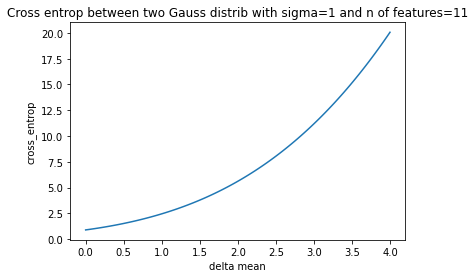

In [4]:
from scipy.stats import norm

x_min = 0
x_max = 10
sigma = 1

# правило трех сигм:  вероятность того, что случайная величина отклонится 
# от своего математического ожидания более чем на три среднеквадратических отклонения, практически равна нулю
distr = np.linspace(x_min, x_max, 11)
me = np.linspace(x_min + 3*sigma, x_max - 3*sigma, 100)
delta_ex = [abs(me.min() - m) for m in me]

p_i = norm.cdf(x=distr, loc=me.min(), scale=sigma)
q_i = np.array([norm.cdf(x=distr, loc=m, scale=sigma) for m in me])

cross_entr_arr = np.sum(-np.log(q_i) * p_i, axis = 1)

plt.xlabel("delta mean")
plt.ylabel("cross_entrop")
plt.title(f"Cross entrop between two Gauss distrib with sigma={sigma} and n of features={len(distr)}")
plt.plot(delta_ex, cross_entr_arr);

#### Неопределенность Джини (Gini impurity)
$$ G = 1 - \sum_{k} (p_k)^2$$
Максимизацию этого критерия можно интерпретировать как максимизацию числа пар
объектов одного класса, оказавшихся в одном поддереве

## Кросс-энтропия и деревья решений
Пример из  https://habr.com/post/171759/

Предположим, что нам надо найти правила разбиения набора данных таким образом, 
чтобы среднее значение энтропии уменьшалось. Это означает, что наше знание о системе __растет__ и этот процесс можно рассматривать как _производство информации_

Если мы разбили исходный набор данных на две части по некому предикату, то можно рассчитать энтропию каждого подмножества. Если после среднее значение энтропии окажется меньшим чем энтропия исходного множества, значит предикат содержит некую обобщающую информацию о данных.

Для примера, рассмотрим множество двухцветных шариков, в котором цвет шарика зависит только от координаты х

<img src="Lesson_09_pics/cross-ent-02.png">

Если мы ограничены простыми предикатами, то одного условия будет недостаточно. Поэтому, 
если повторять эту процедуру рекурсивно для каждого подмножества, мы получим древовидный набор условий, 
который назвается __деревом принятия решений__ (decision tree).

<img src="Lesson_09_pics/cross-ent-03.png">

* листьями дерева принятия решений являются _классы_
* классификация происходит путем спуска вниз по дереву
* процесс спуска можно трактовать как процесс _объяснения_, почему объект отнесен к тому или иному классу

## <font color=green>ВОПРОС</font>
* Можно ли использовать дерево для регрессии?
* Можно ли использовать дерево для кластеризации?

Параметры класса __sklearn.tree._DecisionTreeClassifier___

* __criterion__ (опционально):
    - функция оценки качества разбиеная (”gini” или "entropy")
* __splitter__ (опционально):
    - стратегия, используемая для разбиения в каждом узле (“best” - лучший вариент, “random” - случайное разбиение).
* __max_depth__ (опционально):
    - максимальная глубина дерева
* __min_samples_split__  (опционально):
    - минимальное количество примеров, требуемое для разбиения внутреннего узла.
* __random_state__  (опционально):
    - начальное значение (seed) для генератора случайных чисел

### Параметры дерева

## <font color=green>ВОПРОС</font>
* Зачем ограничивать глубину дерева?
* Зачем ограничивать минимальное количество записей в узле

Когда деревья строятся до максимальной глубины:
* композиция деревьев ("лес", в том числе - случайный (_random forest_)) - усреднение ответов
* стрижка дерева - отсечение вершин за счет сравнения качества дерева с данным разибением и без него

<img src="Lesson_09_pics/dt_iterations.png">

<img src="Lesson_09_pics/reg_dt_path.png">

## Метод ближайших соседей

В основе - выбор ближайших, по некоторому расстоянию, соседей. Предполагается, что каковы ближайшие соседи, 
таков и данный элемент. Метод часто используется как базовый или для построения мета-признаков 
(подается на вход другим моделям).

Алгоритм:
* вычислить попарное расстояние между объектами обучающей выборки
* выбрать $k$ элементов обучающей выборки, расстояние до которых минимально
* класс объекта - это класс, наиболее часто встречающийся среди $k$ ближайших соседей

Параметры метода ближайших соседей
* число соседей ($k$)
* метрика расстояний между объектами (евклидово расстояние, косинусное расстояние, метрика Хэмминга и др.)
* веса соседей (часто зависят от расстояний)

<img src="Lesson_09_pics/An-example-of-kNN-classification-task-with-k-5.png">

Параметры класса __sklearn.neighbors._KNeighborsClassifier___

* __weights__
    - _"uniform"_ - все веса равны
    - _"distance"_ - вес обратно пропорционален расстоянию до тестового примера
    - _другая_ определенная пользователем функция
* __algorithm__ (опционально):
    - _"auto"_ - выбирается автоматически
    - _"brute"_ - считаются полным перебором обучающей выборки
    - _"ball__tree"_ / KD_tree - расстояния хранятся в дереве, что ускоряет поиск соседей
* __leaf_size__ (опционально):
    - порог переключения на полный перебор в случае выбора BallTree или KDTree для нахождения соседей
* __metric__: 
    - _"minkowski"_, _"manhattan"_, _"euclidean"_, _"chebyshev"_ ...

## Кросс-валидация

Основная задача обучаемых алгоритмов - способность работать на новых данных. 
Для проверки обобщающей способности модели наиболее часто используются разбиение тренировочной выборки на две
части: собственно тренировочная (в которую попадает обычно 60-80% от всей выборки) и отложенная 
(проверочная, валидационная). 
Это разбиение может быть сделано несколькими способами:
* "вырезаем" непрерывную часть выборки нужного размера, остальные элементы используются для обучения
* выбираем некоторое количество элементов случайным образом и используем остальные для обучения
* делаем несколько последовательных выборок (непрерывных или случайных), чтобы улучшить нашу оценку
моделей за счет осреднения (кросс-валидация - _cross validation_)

## Кросс-валидация (K-Fold)

<img src="Lesson_09_pics/cross-val-02.png">

используется для:
* выбора модели
* настройки параметров модели
* оценки полезности признаков
Основная проблема - высокая "цена" на больших выборках

Первые два способа реализуются __sklearn.model_selection.train_test_split__, вторые - __model_selection.KFold__

Для сохранения распределения целевых признаков по классам используются StratifiedKFold, StratifiedShuffleSplit

## Применение на базе данных рукописных цифр (MINST)

In [5]:
from sklearn.datasets import load_digits

data = load_digits()
X, y = data.data, data.target

X[0,:].reshape([8,8])

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

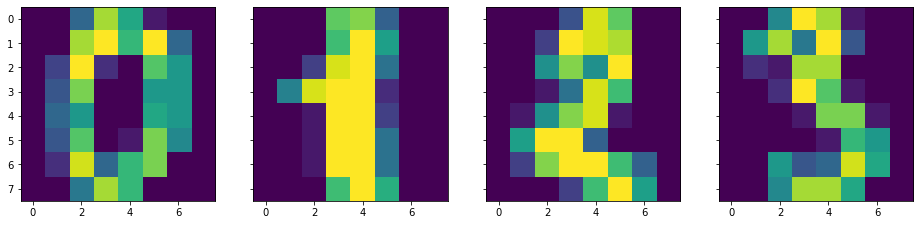

In [6]:
f, axes = plt.subplots(1, 4, sharey=True, figsize=(16,6))
for i in range(4):
    axes[i].imshow(X[i,:].reshape([8,8]));

In [7]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=17)

In [8]:
tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn = KNeighborsClassifier(n_neighbors=10)

tree.fit(X_train, y_train)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [9]:
tree_pred = tree.predict(X_holdout)
knn_pred = knn.predict(X_holdout)
accuracy_score(y_holdout, knn_pred), accuracy_score(y_holdout, tree_pred) # (0.97, 0.666)

(0.9740740740740741, 0.6666666666666666)

In [10]:
tree_params = {'max_depth': [1, 2, 3, 5, 10, 20, 25, 30, 40, 50, 64],
'max_features': [1, 2, 3, 5, 10, 20 ,30, 50, 64]}

tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)

tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed:    6.2s finished


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=5, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 5, 10, 20, 25, 30, 40, 50, 64],
                         'max_features': [1, 2, 3, 5, 10, 20, 30, 50, 64]},
             verbose=True)

In [11]:
tree_grid.best_params_, tree_grid.best_score_ # ({'max_depth': 20, 'max_features': 64}, 0.844)

({'max_depth': 10, 'max_features': 50}, 0.8568203376968316)

In [12]:
np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=1), X_train, y_train, cv=5)) # 0.987

0.9864858028204642

In [13]:
np.mean(cross_val_score(RandomForestClassifier(n_estimators=20, random_state=17), X_train, y_train, cv=5)) # 0.959

0.965790805033833

In [14]:
np.mean(cross_val_score(GradientBoostingClassifier(n_estimators=200, random_state=17), X_train, y_train, cv=5)) # 0.953

0.9586353000695631

Перед домашним заданием __очень__ рекомендуется:
* перечитать https://habr.com/company/ods/blog/322534/
* сделать открытое задание к нему (__сдается на занятии!__ не присылать!):
http://nbviewer.jupyter.org/github/Yorko/mlcourse.ai/blob/master/jupyter_russian/assignments_demo/assignment03_decision_trees.ipynb
(+5 баллов, как и ДЗ)

## <font color="red">ЗАДАНИЕ</font>

* Загрузите датасет https://archive.ics.uci.edu/ml/datasets/Adult
* Примените к нему методы kNN, случайное дерево и ансамбль случайных деревьев



#### Общая информация по данным, которую содержит readme-файл "adult.names"
* в данных Unknown-значения были заменены на "?".
* fnlwgt (final weight) - некая весовая характеристика, определяющая демографию человека, которую составили и использовали эксперты бюро переписи при работе с этой базой.
* workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
* education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
* marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
* occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
* relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
* race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
* sex: Female, Male.
* native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
<br>
* capital-gain: continuous - видимо накопленный капитал за год
* capital-loss: continuous - видимо утерянный капитал за год.
* hours-per-week: continuous - рабочих часов в неделю.
* education_num: continuous - числовая интерпретация (уровень) полученного образования

In [15]:
# Ваш код
col_names = ["age","workclass","fnlwgt","education","education-num","marital-status","occupation","relationship",
            "race","sex","capital-gain","capital-loss","hours-per-week", "native-country","income"]
df_train = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', sep=",\s", 
                       names=col_names, engine='python')
df_test = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', sep=",\s",
                      header=None, names=col_names, engine='python')
#т.к. первая строка в файле не относилась к датасету
df_test.drop(index=0, inplace=True)
df_test.reset_index(drop=True, inplace=True)
#убрать точки из последней колонки
df_test['income'].replace(regex=True, inplace=True, to_replace=r'\.', value=r'')
df = pd.concat([df_train, df_test], ignore_index=True, axis=0)

capital-gain/loss имеет нулевые процентили вплоть до 75% - либо этот признак нерепрезентативен (плохо был собран), либо сильно влияет на очень узкий круг данных

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             48842 non-null  object 
 1   workclass       48842 non-null  object 
 2   fnlwgt          48842 non-null  float64
 3   education       48842 non-null  object 
 4   education-num   48842 non-null  float64
 5   marital-status  48842 non-null  object 
 6   occupation      48842 non-null  object 
 7   relationship    48842 non-null  object 
 8   race            48842 non-null  object 
 9   sex             48842 non-null  object 
 10  capital-gain    48842 non-null  float64
 11  capital-loss    48842 non-null  float64
 12  hours-per-week  48842 non-null  float64
 13  native-country  48842 non-null  object 
 14  income          48842 non-null  object 
dtypes: float64(5), object(10)
memory usage: 5.6+ MB


In [17]:
df['age'] = df['age'].astype(int)

In [18]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [19]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


* Посмотреть пропуски с "?"

In [20]:
space_info = {col : df[col].value_counts()['?'] if any(df[col].value_counts().index == '?') 
              else 0 for col in df.columns}
space_info

{'age': 0,
 'workclass': 2799,
 'fnlwgt': 0,
 'education': 0,
 'education-num': 0,
 'marital-status': 0,
 'occupation': 2809,
 'relationship': 0,
 'race': 0,
 'sex': 0,
 'capital-gain': 0,
 'capital-loss': 0,
 'hours-per-week': 0,
 'native-country': 857,
 'income': 0}

* на фоне размерности данных "?" можно было бы и удалить, но лучше использовать их при обучении как отдельное значение категориального признака (возможна потеря информации по другим признакам). Тем более для дерева решений пропуски в данных не проблема

In [21]:
df_in = df.drop(columns=['income', 'education'], axis=1)
df_to = df['income']
df_categ_dumm = pd.get_dummies(df_in.select_dtypes('object'))
df_num = df_in.select_dtypes(exclude = 'object')
df_num_categ = pd.concat([df_num, df_categ_dumm], axis=1, join='inner')

X_train, X_test, y_train, y_test = train_test_split(df_num_categ, df_to, test_size  = 0.2, random_state=3)

Для начальных моделей возьмем предположительное кол-во выборок разбиения по кол-ву значений в ключевых на первый взгляд категор-х признаках (workclass, образование, пол, раса) + 3 категор-х признака сверху категориальное на ограничение 

In [22]:
#Entropy
entropy_tree = DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 8*16*2*5, min_samples_leaf = 0.005, 
                                      max_features = 8)
# min_samples_split int or float, default=2 - The minimum number of samples (or ratio of init train data if float)
# required to split an internal node

# min_samples_leaf int or float, default=1 - The minimum number of samples (or ratio of init train data if float) 
# required to be at a leaf node

# max_features - The number of features to consider when looking for the best split
entropy_tree = entropy_tree.fit(X_train, y_train)
entr_res = entropy_tree.predict(X_test)
accuracy_score(entr_res, y_test)

0.7627188043812059

In [23]:
# Gini 
gini_tree = DecisionTreeClassifier(criterion = 'gini', min_samples_split = 8*16*2*5, min_samples_leaf = 0.005, 
                                   max_features = 8)
gini_tree = gini_tree.fit(X_train, y_train)
gini_res = gini_tree.predict(X_test)
accuracy_score(gini_res, y_test)

0.8115467294503019

In [24]:
knn = KNeighborsClassifier(n_neighbors=16 * 2) #по образованию (16-значений) и полу (2 значения)
knn = knn.fit(X_train, y_train)
knn_res = knn.predict(X_test)
accuracy_score(knn_res, y_test)

0.7964991299007064

In [25]:
r_f = RandomForestClassifier(n_estimators=20, min_samples_split = 8*16*2*5, min_samples_leaf = 0.005, 
                                   max_features = 8, random_state=5)
r_f = r_f.fit(X_train, y_train)
r_f_res = r_f.predict(X_test)
accuracy_score(r_f_res, y_test)

0.8456341488381616

## Домашнее задание (6 баллов)
https://en.wikipedia.org/wiki/ID3_algorithm
<br>https://en.wikipedia.org/wiki/C4.5_algorithm
<br>https://en.wikipedia.org/wiki/Information_gain_in_decision_trees

Общая схема алгоритма:

```python
def build(L):
    create node t
    if the stopping criterion is True:
        assign a predictive model to t
    else:
        Find the best binary split L = L_left + L_right
        t.left = build(L_left)
        t.right = build(L_right)
    return t  
```

In [26]:
class DecisionTree(object):
    
    """
    В качестве функции потерь используйте логистическую функцию потерь, или же функцию потерь
    для кросс-энтропии sklearn.metrics.log_loss
    """
    def __init__(self, max_tree_depth, min_samples):
        
        self.depth = 0
        self.max_tree_depth = max_tree_depth
        self.min_sample_leaf = min_samples

    def fit(self, X, y):
        
        self.features = list(X.columns)
        
        self.target = y_train.name
        self.classes = np.unique(y)
        df_tmp = X.join(y, how='inner') #cause join works with .index auto
        
        self.tree = self.__createTree(df_tmp)
        print(self.tree)
            
        """
        X - матрица входным параметров n x m, где n(строки) - длина выборки, m(столбцы) - критерии
        по строкам идут элементы выборки, по столбцам - критерии, которые элементы выборки содержат
        y - вектор исходов n, каждое из которых имеет одно из ограниченного множества значений,
            определяющего класс
            
        Предполагается, что для элементов матрицы можно выполнять операции сравнения (<,=,>)

        После выполнения данной функции дерево должно быть обученным и способным предсказывать
        значение
        """
        pass
    
    def __createTree(self, df_tmp, tree=None):
        
        feature, peak = self.__best_info_gain(df_tmp)
        print(feature)
        #categorizing {feature: {feature {feat_value : True/false/type}}
        if tree is None:
            tree = {}
            tree[feature] = {}
        
        if df_tmp[feature].dtype in ('uint8', 'object'):
            
            for feat_val in np.unique(df_tmp[feature]):
                df_tmp_new = df_tmp[df_tmp[feature] == feat_val]
                target_group = df_tmp_new[self.target].value_counts()
                if target_group.shape[0] == 1:
                    tree[feature][feat_val] = target_group.index[0] 
                else:
                    self.depth += 1
                    tree[feature][feat_val] = target_group.index[0] if self.max_tree_depth <= self.depth else self.__createTree(df_tmp_new)
        
        else:
            self.depth += 1
            
            df_left_new = df_tmp[df_tmp[feature] <= peak]
            df_right_new = df_tmp[df_tmp[feature] > peak]
            
            target_group_left = df_left_new[self.target].value_counts() #тут может быть пусто
            if target_group_left.shape[0] == 1:
                tree[feature]['<=' + str(peak)] = target_group_left.index[0]#iloc[0] может быть пусто
            else:
                tree[feature]['<=' + str(peak)] = target_group_left.index[0] if self.max_tree_depth <= self.depth else self.__createTree(df_left_new)
                
            target_group_right = df_right_new[self.target].value_counts()#тут может быть пусто
            if target_group_right.shape[0] == 1:
                tree[feature]['>' + str(peak)] = target_group_right.index[0]
            else:
                tree[feature]['>' + str(peak)] = target_group_right.index[0] if self.max_tree_depth <= self.depth else self.__createTree(df_right_new)
                
        return tree
            
    def __best_info_gain(self, df_tmp):
        inf_gains = []
        thresholds = []
        
        for feature in self.features:
            entr = self.__get_entropy(df_tmp[self.target])
            cross_entr, threshld = self.__get_cross_entropy(df_tmp, feature)
            info_gain = entr - cross_entr
            inf_gains.append(info_gain)
            thresholds.append(threshld)
#             print(info_gain)
            
        
        best_id = np.argmax(inf_gains)
        return df_tmp.columns[best_id], thresholds[best_id]
            
    def __get_entropy(self, y):
        frq_s = [y[y == val].shape[0] / y.shape[0] for val in self.classes]
        entrop = sum(map(lambda x: -x*np.log2(x), frq_s))
        return entrop
                     
    def __get_cross_entropy(self, df_tmp, feature):
        
        cross_entropy = 0
        threshold = None
#         print(df_tmp.info(), feature)
        cross_df = df_tmp[[feature, self.target]] ##!!!! "['workclass_?'] not in index"
        
        if cross_df[feature].dtype in ('uint8', 'object'):
            for feat_val in np.unique(cross_df[feature]):
#                 print(feat_val)
                tmp_entr = 0
                for val in self.classes:
                    n_i = cross_df[(cross_df[feature]==feat_val) & (cross_df[self.target] == val)][feature].shape[0]
                    n = cross_df[cross_df[feature]==feat_val].shape[0] 
#                     print(frq)
                    frq = n_i / n if (n_i != 0) & (n != 0) else 0
                    if frq != 0:
                        tmp_entr += -(frq)*np.log2(frq)
#                     print(tmp_entr)

                rat = cross_df[cross_df[feature] == feat_val].shape[0] / cross_df.shape[0]
                cross_entropy += rat * tmp_entr
#                 print(cross_entropy)
        
        else:
            cross_entropy = 1
            prev_val = 0
            
            #здесь: если большие числа - разбить на коробки, иначе очень долго работает
            
            for feat_val in np.unique(cross_df[feature]):
                peak = (feat_val + prev_val) / 2
                cur_entr = 0
                
                for cs in ('<', '>'):
                    tmp_entr = 0
                    
                    for val in self.classes:
                        n_i, n = (0, 0) 
                        if cs == '<':
                            n_i = cross_df[(cross_df[feature] < feat_val) & (cross_df[self.target] == val)][feature].shape[0]
                            n = cross_df[cross_df[feature] < feat_val].shape[0]
                            #print(n_i, n)
                        else:
                            n_i = cross_df[(cross_df[feature] > feat_val) & (cross_df[self.target] == val)][feature].shape[0]
                            n = cross_df[cross_df[feature] > feat_val].shape[0]
                            #print(n_i, n)
                        frq = n_i / n if (n_i != 0) & (n != 0) else 0
                        if frq != 0:
                            tmp_entr += -(frq)*np.log2(frq)
                    rat = n / cross_df.shape[0]
                    cur_entr += rat * tmp_entr
                if cur_entr < cross_entropy:
                    cross_entropy = cur_entr
                    threshold = peak
                prev_val = feat_val
                #print(cross_entropy, prev_val) на больших данных с большими числовыми хар-ками - оч долго
        return cross_entropy, threshold
    
    def predict(self, X):
        
        test_features = X.dtypes
#         for x in X - just column titles
        results = np.array([self.__predict_tree(X.iloc[i], test_features, self.tree) for i in range(X.shape[0])])
        return results
        
        
        """
        Выводит вектор предсказаний для заданной матрицы X
        """    
    def __predict_tree(self, data_row, features_types, root):
#         print(root.keys())
        for feature in root.keys():
            value = data_row[feature]
            if features_types[features_types.index == feature].item() in ('uint8', 'object'):
                tree_node = root[feature][value]
            else:
                peek_str = root[feature].keys()[0].split('<=')[1]
                tree_node = root[feature]['<='+peek_str] if float(peek_str) <= value else root[feature]['>'+str(peek_str)]
            
            res = None
            
            if type(tree_node) is dict: 
                res = self.__predict_tree(data_row, features_types, tree_node)
            else:
                res = tree_node
            return res
            

* На численных данных моя реализация работает очень медленно, поэтому я посмотрел ее работа на категориальных признаках

In [27]:
my_train, my_test, l_train, l_test=train_test_split(df_in.select_dtypes('object'), df_to, test_size  = 0.1, random_state=2)
my_tree = DecisionTree(max_tree_depth = 4, min_samples = 0.005)
my_tree.fit(my_train, l_train)

relationship
occupation
native-country
race
{'relationship': {'Husband': {'occupation': {'?': {'native-country': {'?': {'race': {'Asian-Pac-Islander': '<=50K', 'White': '<=50K'}}, 'Canada': '<=50K', 'China': '<=50K', 'Columbia': '<=50K', 'Cuba': '<=50K', 'Dominican-Republic': '<=50K', 'Ecuador': '<=50K', 'El-Salvador': '<=50K', 'Germany': '<=50K', 'Haiti': '<=50K', 'Hungary': '<=50K', 'Ireland': '>50K', 'Italy': '>50K', 'Mexico': '<=50K', 'Nicaragua': '<=50K', 'Philippines': '<=50K', 'Poland': '<=50K', 'Portugal': '<=50K', 'Puerto-Rico': '<=50K', 'South': '<=50K', 'United-States': '<=50K', 'Vietnam': '<=50K'}}, 'Adm-clerical': '<=50K', 'Armed-Forces': '>50K', 'Craft-repair': '<=50K', 'Exec-managerial': '>50K', 'Farming-fishing': '<=50K', 'Handlers-cleaners': '<=50K', 'Machine-op-inspct': '<=50K', 'Other-service': '<=50K', 'Priv-house-serv': '<=50K', 'Prof-specialty': '>50K', 'Protective-serv': '<=50K', 'Sales': '>50K', 'Tech-support': '>50K', 'Transport-moving': '<=50K'}}, 'Not-in-fami

In [28]:
my_result = my_tree.predict(my_test)

In [29]:
accuracy_score(my_result, l_test)

0.8139201637666326